## Limpieza Inicial de Datos, Unión de Tablas y Formateo de Fechas

Se requiere de un conjunto de datos limpio, es decir, que no se presenten entradas nulas o NaN’s, que el formato de fechas sea el mismo para todos los valores y que los atributos estén en forma de columnas i.e. que cada variable meteorológica o de contaminantes estén en una columna separada, entre otras propiedades que se describirán a continuación.

El proceso de limpieza de datos consiste en hacer un conjunto de manipulaciones a la tablas para generar un dataset óptimo. A continuación, se muestra el diagrama de la limpieza de datos realizada:


<img src="./diagrama.png" style="height:200px">

__Pasos y descripción general del notebook__

1. __Descarga de Tablas:__ Los datos de contaminantes y meteorología son descargados por separado. Los datos usados para el entrenamiento son verificados de manera manual por la SEDEMA. En este notebook vamos a juntar los archivos de contaminación y meoteorología de cada año en un solo archivo, también se eliminan las entradas vacías. 


2. __Convertir a tabla con variables por columna__: Se pasa de tener una columna que indica el atributo medido y otro el valor de la medición a una columna por cada atribute que indica el valor de la medición.


3. __Formateo de Fechas:__ se arreglará el formato de fechas al formato **YY/m/d hh:mm** con horas de 0 a 23 y también vamos a generar columnas de información temporal con parámetros como hora, día y mes para cada medición 


- __Datos recibidos:__ [Meteorología,](http://www.aire.cdmx.gob.mx/default.php?opc='aKBhnmI='&opcion=Zw==)
[Contamianción](http://www.aire.cdmx.gob.mx/default.php?opc='aKBhnmI='&opcion=Zg==)
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [18]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
import seaborn as sns
from datetime import datetime, timedelta

from datetime import timedelta
import datetime as dt
from tqdm import tqdm

## Presentación de los datos utilizados

El Sistema de Monitoreo Atmosférico de la Ciudad de México presenta de forma horaria desde el año 1986 las condiciones meteorológicas y de contaminación que describen la atmósfera de la zona metropolitana. La información descrita se presenta de dos formas: puede ser una base de datos revisada por expertos de la SEDEMA para descartar mediciones de fuentes atípicas de contaminación tales como incendios o desperfectos en las estaciones de monitoreo, o no revisada, obteniendo directamente la medición como se midió en la estación de monitoreo. Esta falta de consistencia de la información puede generar valores erróneos en el pronóstico generado, limitando el desempeño de los modelos. Por este motivo, los datos de monitoreo usados para el entrenamiento de los modelos son los datos revisados por los expertos.

Para el entrenamiento de los modelos los datos usados abarcan el periodo de enero 2014 hasta diciembre 2018, accesibles en la sección de datos Horarios por contaminante y de datos horarios de Meteorología. Las variables meteorológicas y de contaminación utilizadas para el desarrollo del modelo se muestra en la siguiente tabla:

<img src="./table_attributes.png" style="height:250px">

Las estaciones en operación se distribuyen en el área metropolitana, concentrándose en la zona central de la CDMX. En la siguiente figura se muestra la posición geográﬁca de las estaciones.

<img src="./mapa.png" style="height:350px">



Como parte del proceso de la generación de los modelos de pronóstico de contamianción, es necesario realizar un conjunto de operaciones a los datos obtenidos de la página de [Monitoreo de Calidad del Aire de la Ciudad de México](http://www.aire.cdmx.gob.mx/default.php). Como se mencionó en el archivo de metodología, los datos a usar son los datos verificados por los expertos de la SEDEMA. Los datos para meteorología y contaminanción se pueden obtener acontinuación:

- [Meteorología](http://www.aire.cdmx.gob.mx/default.php?opc='aKBhnmI='&opcion=Zw==)
- [Contamianción](http://www.aire.cdmx.gob.mx/default.php?opc='aKBhnmI='&opcion=Zg==)



Juntaremos los dataframes con una PivotTable y las agruparemos por el momento de la medición

#### Definimos tres funciones para formatear el formato de las fechas:

Convertir el formato de 1 a 24 horas al formato de 0 a 23 horas. Por defecto python trabaja con el formato de 0 a 23 horas, es conveniente trabajar en este formato debido a que muchas de las funciones implementadas en python u otras librerias suponen que este es el formato de las fechas.

El formato original de las fechas, es d/m/YY h:m y el formato despuésde aplicar la función es YY/m/d hh:mm. 

In [19]:
def time_converter(x):
    x0 = x.split(" ")[0]
    x0 = x0.split("/")
    x1 = x.split(" ")[1]
    if x1[:].endswith("24:00"):
        # Notemos que cuando la hora es 24, es necesario convertirla a 00 sin embargo también es necesario
        # esta fecha se desplazará al siguiente día, es deicr, si se tiene '19-05-01 24:00', al terminar con "24",
        # se sustituirá por '19-05-02 00:00'
        # Considerando esto, se aplica lasiguiente función:
        fecha_0 = x0[2]+"-"+x0[1]+"-"+x0[0]+" 23:00"
        date = datetime.strptime(fecha_0, "%Y-%m-%d %H:%M")
        new_time = date + timedelta(hours=1)
        return new_time.strftime('%Y-%m-%d %H:%M')
    else:
        return x0[2]+"-"+x0[1]+"-"+x0[0]+" "+ x1[:]

Definamos el año a limpiar:

In [20]:
target = "meteorologia"
target = "contaminantes"
anio = "2015"

A continuación se define una función que realizará los siguientes procesos:
 
 - Leer el archivo de contaminantes o meteorología del año seleccionado.
 - Eliminar las entradas vacías
 - Hacer una tabla pivote para pasar de una columna con el nombre del atributo y su valor a una columna por atributo.
 - Convertir la columna fecha de d/m/yy hh:mm a yy/mm/dd hh:mm y pasar del formato de horas de 1..24 a 0...23.
 

In [21]:
met_2018 = pd.read_csv(str('./datasets/' + target + "/" + target + "_" + str(anio) + ".csv"),header=10) # leer archivo

In [22]:
if "cve_station" in met_2018.columns or "cve_parameter" in met_2018.columns:
    met_2018.rename(columns={'cve_station': 'id_station', 'cve_parameter': 'id_parameter'}, inplace=True) # checar nombre columbas

In [23]:
met_2018['hora'] = met_2018['date'].astype(str).str[-5:-3].astype(int)
met_2018 = met_2018.dropna(subset=["value"]).reset_index(drop=True)#PM25

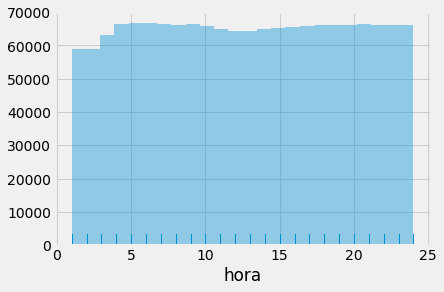

In [24]:
sns.distplot(met_2018["hora"], bins=24, kde=False, rug=True);

### Juntemos este proceso en una función, se aplicará a meteorología y contaminantes

In [51]:
def formateo_csv(target, anio):   
    #leemos el archivo
    met_2018 = pd.read_csv(str('../data/raw/' + target + "/" + target + "_" + str(anio) + ".csv"),header=10)
    if "cve_station" in met_2018.columns or "cve_parameter" in met_2018.columns:
        met_2018.rename(columns={'cve_station': 'id_station', 'cve_parameter': 'id_parameter'}, inplace=True)
    #eliminamos las entradas vacías
    met_2018 = met_2018.dropna(how='any')
    met_2018 = met_2018.drop(['unit'], axis=1)
    
    met_ACO = met_2018
    met_ACO = met_ACO.reset_index(drop=False)
    met_ACO = met_ACO[["date","id_station","id_parameter","value"]] # nos quedamos con las siguientes columnas:

    #Hacer una tabla pivote para pasar de una columna con el nombre del atributo
                            # y su valor a una columna por atributo.
    met_ACO_hour = pd.pivot_table(met_ACO,index=["date","id_station"],columns=["id_parameter"])
    met_ACO_hour = met_ACO_hour.reset_index(drop=False)
    met_ACO_hour.columns = met_ACO_hour.columns.droplevel()
    met_ACO_hour["id_station"] = met_ACO_hour.iloc[:,1]
    met_ACO_hour["date"] = met_ACO_hour.iloc[:,0]
    
    #eliminamos la columna vacía
    met_ACO_hour = met_ACO_hour.drop([""],axis=1)
    
    # Convertir la columna fecha de d/m/yy hh:mm a yy/mm/dd hh:mm y pasar del formato de horas de 1..24 a 0...23.
    met_ACO_hour['date'] = met_ACO_hour.apply(lambda row: time_converter(row['date']), axis=1) 
    met_ACO_hour['date'] =  pd.to_datetime(met_ACO_hour['date'], format='%Y-%m-%d %H:%M')
    met_ACO_hour = met_ACO_hour.rename(columns={'date': 'fecha'})
    
    return(met_ACO_hour)

Ejecutamos la función anterior para los datos de metereología y contaminantes:

In [52]:
target1 = "meteorologia"
anio = "2019"
meteorologia = formateo_csv(target1, anio)
target2 = "contaminantes"
contaminacion = formateo_csv(target2, anio)

In [53]:
meteorologia.head()

id_parameter,RH,TMP,WDR,WSP,id_station,fecha
0,74.0,10.0,318.0,0.9,ACO,2019-01-01 01:00:00
1,53.0,NaN,191.0,5.1,AJM,2019-01-01 01:00:00
2,NaN,NaN,197.0,2.3,AJU,2019-01-01 01:00:00
3,65.0,12.7,154.0,1.4,BJU,2019-01-01 01:00:00
4,63.0,7.3,100.0,1.1,CHO,2019-01-01 01:00:00


# Merge de Dataframes   <a class="anchor" id="merge-bullet"></a>

Juntamos los dataframes generados, así podremos trabajar con ambos archivos a la vez:

In [54]:
data_hour_merge = pd.merge(meteorologia, contaminacion, on=["fecha","id_station"],how="outer")

Generamos 3 columnas con la información temporal del momento en que se tomó la medición
en la columna de fecha se elimina la información de hora y minuto.

In [55]:
data_hour_merge['hora'] = data_hour_merge['fecha'].astype(str).str[10:13].astype(int)
data_hour_merge['dia'] = data_hour_merge['fecha'].astype(str).str[8:10].astype(int)
data_hour_merge['mes'] = data_hour_merge['fecha'].astype(str).str[5:7].astype(int)
data_hour_merge['fecha'] = data_hour_merge['fecha'].astype(str).str[0:10]

In [56]:
data_hour_merge.head(5)

id_parameter,RH,TMP,WDR,WSP,id_station,fecha,CO,NO,NO2,NOX,O3,PM10,PM2.5,PMCO,SO2,hora,dia,mes
0,74.0,10.0,318.0,0.9,ACO,2019-01-01,NaN,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,1,1,1
1,53.0,NaN,191.0,5.1,AJM,2019-01-01,NaN,NaN,NaN,NaN,NaN,42.0,23.0,19.0,NaN,1,1,1
2,NaN,NaN,197.0,2.3,AJU,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1
3,65.0,12.7,154.0,1.4,BJU,2019-01-01,NaN,NaN,NaN,NaN,NaN,64.0,47.0,17.0,NaN,1,1,1
4,63.0,7.3,100.0,1.1,CHO,2019-01-01,NaN,NaN,NaN,NaN,NaN,81.0,NaN,NaN,NaN,1,1,1


### Una vez que corroboramos el correcto funcionamiento del proceso, podemos juntar los pasos anteriores en una función y así agilizar el proceso de la limpieza de cada año:

In [57]:
def data_parser(anio_1):
    print(anio_1)
    target1 = "meteorologia"
    meteorologia = formateo_csv(target1, anio_1)
    target2 = "contaminantes"
    contaminacion = formateo_csv(target2, anio_1)

    data_hour_merge = pd.merge(meteorologia, contaminacion, on=["fecha","id_station"],how="outer")

    data_hour_merge['hora'] = data_hour_merge['fecha'].astype(str).str[10:13]
    data_hour_merge['dia'] = data_hour_merge['fecha'].astype(str).str[8:10]
    data_hour_merge['mes'] = data_hour_merge['fecha'].astype(str).str[5:7]
    data_hour_merge['fecha'] = data_hour_merge['fecha'].astype(str).str[0:10]
    data_hour_merge.to_csv(str("../data/processed/met_cont_hora/cont_hora"+ 
                               str(anio_1) +".csv"))

Corremos la función desde el 2012 al 2019:

In [58]:
[data_parser(str(anio)) for anio in range(2018,2021)]

2018
2019
2020


[None, None, None]